# 0. Imports

In [2]:
try:
    from ssm_jax.cond_moments_gaussian_filter.inference import _condition_on
    from ssm_jax.cond_moments_gaussian_filter.containers import EKFParams, UKFParams, GHKFParams
    from ssm_jax.cond_moments_gaussian_filter.demos.cmgf_mlp_classifier import *
except ModuleNotFoundError:
    print('installing ssm_jax')
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    from ssm_jax.cond_moments_gaussian_filter.inference import _condition_on
    from ssm_jax.cond_moments_gaussian_filter.containers import EKFParams, UKFParams, GHKFParams
    from ssm_jax.cond_moments_gaussian_filter.demos.cmgf_mlp_classifier import *

In [3]:
%pip install optax
%pip install chex
%pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
import collections.abc
import warnings
from typing import Callable

from jax.tree_util import tree_map
from jax import vmap
import jax.numpy as jnp
import optax
import flax
import chex

# 1. CMGF Optimizer

In [70]:
from typing import Callable
from itertools import product
from dataclasses import dataclass, field

from numpy.polynomial.hermite_e import hermegauss
from jax import jacfwd
from jax import vmap
import jax.numpy as jnp
import chex


_jacfwd_2d = lambda f, x: jnp.atleast_2d(jacfwd(f)(x))

@chex.dataclass
class CMGFParams:
    """Lightweight container for CMGF parameters.
    """
    initial_mean: chex.Array
    initial_covariance: chex.Array
    dynamics_function: Callable
    dynamics_covariance: chex.Array
    emission_mean_function: Callable
    emission_cov_function: Callable
    gaussian_expectation: Callable
    gaussian_cross_covariance: Callable


@chex.dataclass
class EKFParams(CMGFParams):
    """
    Lightweight container for extended Kalman filter/smoother parameters.
    """
    gaussian_expectation: Callable = lambda f, m, P: jnp.atleast_1d(f(m))
    gaussian_cross_covariance: Callable = lambda f, g, m, P: _jacfwd_2d(f, m) @ P @ _jacfwd_2d(g, m).T


@dataclass
class SigmaPointParams(CMGFParams):
    """
    Lightweight container for sigma point filter/smoother parameters.
    """
    def _gaussian_expectation(self, f, m, P):
        w_mean, _, sigmas = self.compute_weights_and_sigmas(m, P)
        return jnp.atleast_1d(jnp.tensordot(w_mean, vmap(f)(sigmas), axes=1))

    def _gaussian_cross_covariance(self, f, g, m, P):
        _, w_cov, sigmas = self.compute_weights_and_sigmas(m, P)
        _outer = vmap(lambda x, y: jnp.atleast_2d(x).T @ jnp.atleast_2d(y), 0, 0)
        f_mean, g_mean = self.gaussian_expectation(f, m, P), self.gaussian_expectation(g, m, P)
        return jnp.atleast_2d(jnp.tensordot(w_cov, _outer(vmap(f)(sigmas) - f_mean, vmap(g)(sigmas) - g_mean), axes=1))


@dataclass
class UKFParams(SigmaPointParams):
    """
    Lightweight container for unscented Kalman filter/smoother parameters.
    """
    alpha: chex.Scalar = jnp.sqrt(3)
    beta: chex.Scalar = 2
    kappa: chex.Scalar = 1
    compute_weights_and_sigmas: Callable = lambda x, y: (0, 0, 0)
    gaussian_expectation: Callable = None
    gaussian_cross_covariance: Callable = None
    
    def __post_init__(self):
        self.compute_weights_and_sigmas = self._compute_weights_and_sigmas
        self.gaussian_expectation = super()._gaussian_expectation
        self.gaussian_cross_covariance = super()._gaussian_cross_covariance

    def _compute_weights_and_sigmas(self, m, P):
        n = len(m)
        lamb = self.alpha**2 * (n + self.kappa) - n
        # Compute weights
        factor = 1 / (2 * (n + lamb))
        w_mean = jnp.concatenate((jnp.array([lamb / (n + lamb)]), jnp.ones(2 * n) * factor))
        w_cov = jnp.concatenate((jnp.array([lamb / (n + lamb) + (1 - self.alpha**2 + self.beta)]), jnp.ones(2 * n) * factor))
        # Compute sigmas
        distances = jnp.sqrt(n + lamb) * jnp.linalg.cholesky(P)
        sigma_plus = jnp.array([m + distances[:, i] for i in range(n)])
        sigma_minus = jnp.array([m - distances[:, i] for i in range(n)])
        sigmas = jnp.concatenate((jnp.array([m]), sigma_plus, sigma_minus))
        return w_mean, w_cov, sigmas


@dataclass
class GHKFParams(SigmaPointParams):
    """
    Lightweight container for Gauss-Hermite Kalman filter/smoother parameters.
    """
    order: chex.Scalar = 10
    compute_weights_and_sigmas: Callable = lambda x, y: (0, 0, 0)
    gaussian_expectation: Callable = None
    gaussian_cross_covariance: Callable = None
    
    def __post_init__(self):
        self.compute_weights_and_sigmas = self._compute_weights_and_sigmas
        self.gaussian_expectation = super()._gaussian_expectation
        self.gaussian_cross_covariance = super()._gaussian_cross_covariance

    def _compute_weights_and_sigmas(self, m, P):
        n = len(m)
        samples_1d, weights_1d = hermegauss(self.order)
        weights_1d /= weights_1d.sum()
        weights = jnp.prod(jnp.array(list(product(weights_1d, repeat=n))), axis=1)
        unit_sigmas = jnp.array(list(product(samples_1d, repeat=n)))
        sigmas = m + vmap(jnp.matmul, [None, 0], 0)(jnp.linalg.cholesky(P), unit_sigmas)
        return weights, weights, sigmas


In [72]:
@chex.dataclass
class EKFOptimizerParams:
    gaussian_expectation: Callable = EKFParams.gaussian_expectation
    gaussian_cross_covariance: Callable = EKFParams.gaussian_cross_covariance

@chex.dataclass
class UKFOptimizerParams:
    alpha: chex.Scalar = 1e-3
    beta: chex.Scalar = 2
    kappa: chex.Scalar = 1
    gaussian_expectation: Callable = None
    gaussian_cross_covariance: Callable = None

    def __post_init__(self):
        ukf_params = UKFParams(
            initial_mean=None,
            initial_covariance=None,
            dynamics_function=None,
            dynamics_covariance=None,
            emission_mean_function=None,
            emission_cov_function=None,
            alpha=self.alpha,
            beta=self.beta,
            kappa=self.kappa
        )
        self.gaussian_expectation = ukf_params.gaussian_expectation
        self.gaussian_cross_covariance = ukf_params.gaussian_cross_covariance

@chex.dataclass
class GHKFOptimizerParams:
    order: chex.Scalar = 5
    gaussian_expectation: Callable = None
    gaussian_cross_covariance: Callable = None

    def __post_init__(self):
        ghkf_params = GHKFParams(
            initial_mean=None,
            initial_covariance=None,
            dynamics_function=None,
            dynamics_covariance=None,
            emission_mean_function=None,
            emission_cov_function=None,
            order=self.order
        )
        self.gaussian_expectation = ghkf_params.gaussian_expectation
        self.gaussian_cross_covariance = ghkf_params.gaussian_cross_covariance

In [109]:
def check_optimizer_initial_params(filter_type, num_iter, alpha, beta, kappa, order):
    if not isinstance(num_iter, int) or num_iter < 1:
        raise ValueError(
            f"num_iter={num_iter} is not a valid num_iter value. Input a positive integer."
        )
    params = {'alpha': alpha, 'beta': beta, 'kappa': kappa, 'order': order}
    for param_key, param_val in params.items():
        if param_key == 'order':
            if (isinstance(param_val, int) and param_val < 1) or (not isinstance(param_val, int) and param_val):
                raise ValueError(
                    f"{param_key}={param_val} is not a valid {param_key} value. "
                    "Input a positive integer."
                )
        else:
            if (isinstance(param_val, float) and param_val < 0) or (not isinstance(param_val, int) and param_val):
                raise ValueError(
                    f"{param_key}={param_val} is not a valid {param_key} value. "
                    "Input a non-negative number."
                )

    warning_message = lambda param_key, param_val, filter_type: (f"Concrete value for {param_key}={param_val} was provided. "
                                                                 f"This will be ignored by the cmgf-{filter_type} optimizer.")
    if filter_type == 'ekf':
        for param_key, param_val in params.items():
            if param_val:
                warnings.warn(
                    warning_message(param_key, param_val, filter_type)
                )
        filter = EKFOptimizerParams()
    elif filter_type == 'ukf':
        if params['order']:
            warnings.warn(
                warning_message('order', params['order'], filter_type)
            )
        ukf_default_dict = {'alpha': jnp.sqrt(3), 'beta': 2, 'kappa': 1}
        for param_key, param_val in ukf_default_dict.items():
            if not params[param_key]:
                params[param_key] = ukf_default_dict[param_key]
        filter = UKFOptimizerParams(alpha=params['alpha'], beta=params['beta'], kappa=params['kappa'])
    elif filter_type == 'ghkf':
        for param_key, param_val in params.items():
            if param_key != 'order' and param_val:
                warnings.warn(
                    warning_message(param_key, param_val, filter_type)
                )
        if not params['order']:
            params['order'] = 5
        filter = GHKFOptimizerParams(order=params['order'])
    else:
        raise ValueError(
            f"{filter_type} is not a valid filter_type. Input one of 'ekf', 'ukf', or 'ghkf'."
        )
    return [filter, num_iter] + list(params.values())

In [110]:
@chex.dataclass
class CMGFOptimizerParams:
    mean: jnp.ndarray
    cov: jnp.ndarray

In [111]:
def check_optimizer_params(params, params_name):
    if isinstance(params, CMGFOptimizerParams):
        return params
    if not isinstance(params, collections.abc.Sequence):
        raise ValueError(
            f"'{params_name}' object of type {type(params)} was provided. Provide a valid CMGFOptimizerParams object."
        )
    if len(params) != 2:
        raise ValueError(
            f"'{params_name}' object of length {len(params)} was provided. Input a valid object of length 2."
        )
    return CMGFOptimizerParams(mean=params[0], cov=params[1])

In [112]:
class CMGFOptimizer:
    def __init__(self, filter_type='ekf', num_iter=1, alpha=None, beta=None, kappa=None, order=None):
        self._filter, self._num_iter, self._alpha, self._beta, self._kappa, self._order = \
            check_optimizer_initial_params(filter_type, num_iter, alpha, beta, kappa, order)

    def init(self, params: CMGFOptimizerParams):
        return check_optimizer_params(params, 'params')

    def update(self, x, pred_mean_fn, pred_cov_fn, true_y, opt_state):
        prior_mean, prior_cov = check_optimizer_params(opt_state, 'opt_state').values()
        g_ev, g_cov = self._filter.gaussian_expectation, self._filter.gaussian_cross_covariance
        _, mean, cov = _condition_on(prior_mean, prior_cov, pred_mean_fn, pred_cov_fn,
                                     x, true_y, g_ev, g_cov, self._num_iter)
        post_opt_state = CMGFOptimizerParams(mean=mean, cov=cov)
        updates = mean - prior_mean
        return updates, post_opt_state

# 2. MLP Classifier Example

We set up some groundwork.

In [162]:
def evaluate_and_plot(input_grid, params, predict_fn, input, output):
    # Evaluate the trained MLP on grid and plot
    Z_cmgf = posterior_predictive_grid(input_grid, params, predict_fn, binary=False)
    fig, ax = plt.subplots(figsize=(6, 5))
    title = "CMGF-EKF One-Pass Trained MLP Classifier"
    plot_posterior_predictive(ax, input, output, title, input_grid, Z_cmgf);

In [163]:
# Generate spiral dataset
input, output = generate_spiral_dataset()

# Define grid on input space
input_grid = generate_input_grid(input)

In [176]:
# Define MLP architecture
input_dim, hidden_dims, output_dim = 2, [15, 15], 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)

# Define model and initial opt_state
state_dim, emission_dim = flat_params.size, output_dim
eps = 1e-4
sigmoid_fn = lambda w, x: jnp.clip(jax.nn.sigmoid(apply_fn(w, x)), eps, 1-eps) # Clip to prevent divergence
pred_mean_fn = lambda w, x: sigmoid_fn(w, x)
pred_cov_fn = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))
initial_mean=flat_params
initial_covariance=jnp.eye(state_dim)

In [177]:
def fit(opt_state, optimizer, input, output, pred_mean_fn, pred_cov_fn):
    params = opt_state.mean

    @jax.jit
    def step(params, opt_state, x, y):
        updates, opt_state = optimizer.update(x, pred_mean_fn, pred_cov_fn, y, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state
    
    for i, (x, y) in enumerate(zip(input, output)):
        params, opt_state = step(params, opt_state, x, y)
    
    return params

Next, we try some experiments.

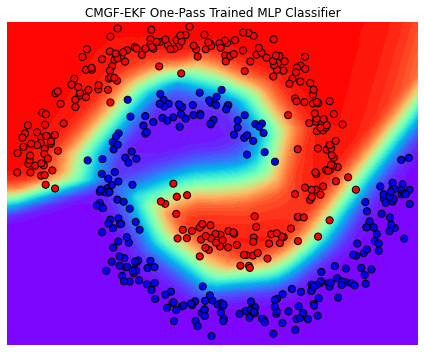

In [178]:
# Initialize cmgf-ekf optimizer
ekf_optimizer = CMGFOptimizer('ekf')
opt_state = CMGFOptimizerParams(mean=initial_mean, cov=initial_covariance)
params = fit(opt_state, ekf_optimizer, input, output, pred_mean_fn, pred_cov_fn)

evaluate_and_plot(input_grid, params, sigmoid_fn, input, output)

Next we simplify the model to decrease the predictive power.

In [185]:
# Define MLP architecture
input_dim, hidden_dims, output_dim = 2, [7, 7], 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)

# Define model and initial opt_state
state_dim, emission_dim = flat_params.size, output_dim
eps = 1e-4
sigmoid_fn = lambda w, x: jnp.clip(jax.nn.sigmoid(apply_fn(w, x)), eps, 1-eps) # Clip to prevent divergence
pred_mean_fn = lambda w, x: sigmoid_fn(w, x)
pred_cov_fn = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))
initial_mean=flat_params
initial_covariance=jnp.eye(state_dim)

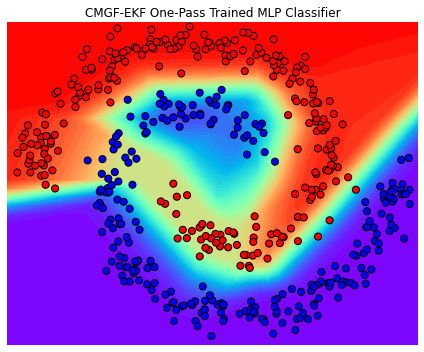

In [186]:
# Initialize cmgf-ekf optimizer
ekf_optimizer = CMGFOptimizer('ekf')
opt_state = CMGFOptimizerParams(mean=initial_mean, cov=initial_covariance)
params = fit(opt_state, ekf_optimizer, input, output, pred_mean_fn, pred_cov_fn)

evaluate_and_plot(input_grid, params, sigmoid_fn, input, output)

Note below that iterated posterior linearization is able to make better predictions despite the limiting simplicity of the model. However, training takes longer.

In [189]:
# Initialize cmgf optimizer
ekf_optimizer = CMGFOptimizer('ekf', 40)
opt_state = CMGFOptimizerParams(mean=initial_mean, cov=initial_covariance)
params = fit(opt_state, ekf_optimizer, input, output, pred_mean_fn, pred_cov_fn)

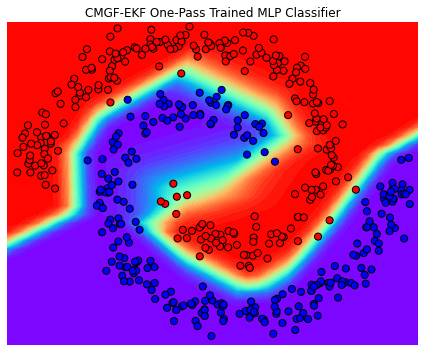

In [190]:
evaluate_and_plot(input_grid, params, sigmoid_fn, input, output)